In [1]:
import yfinance as yf
import pandas as pd
from matplotlib import pyplot

# Read and print the stock tickers that make up S&P500
tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
print(tickers.head())

# Get the data for this tickers from yahoo finance
data = yf.download(tickers.Symbol.to_list(),'2008-1-1','2021-7-12', auto_adjust=True)['Close']
print(data.head())

  Symbol             Security SEC filings             GICS Sector  \
0    MMM                   3M     reports             Industrials   
1    ABT  Abbott Laboratories     reports             Health Care   
2   ABBV               AbbVie     reports             Health Care   
3   ABMD              Abiomed     reports             Health Care   
4    ACN            Accenture     reports  Information Technology   

                GICS Sub-Industry    Headquarters Location Date first added  \
0        Industrial Conglomerates    Saint Paul, Minnesota       1976-08-09   
1           Health Care Equipment  North Chicago, Illinois       1964-03-31   
2                 Pharmaceuticals  North Chicago, Illinois       2012-12-31   
3           Health Care Equipment   Danvers, Massachusetts       2018-05-31   
4  IT Consulting & Other Services          Dublin, Ireland       2011-07-06   

       CIK      Founded  
0    66740         1902  
1     1800         1888  
2  1551152  2013 (1888)  
3   81

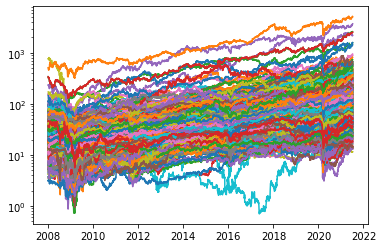

In [2]:
pyplot.plot(data)
pyplot.yscale('log')
pyplot.show()

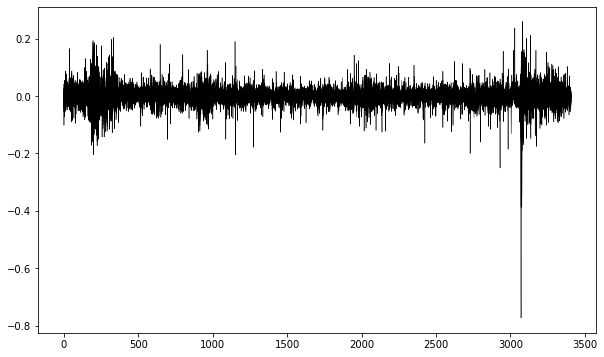

In [103]:
import numpy
pyplot.figure(figsize=(10,6))
np_data = data.to_numpy()
pyplot.plot(numpy.diff(numpy.log(np_data[1:-1:,::40]), axis=0), 'k', lw=.5)
pyplot.show()

In [95]:
numpy.log(np_data[2:,::20] / np_data[1:-1:,::20]).shape

(3409, 26)

In [96]:
from sklearn.decomposition import PCA
from scipy.stats import zscore

In [104]:
pca = PCA()
X = numpy.diff(numpy.log(np_data[2:,::40]), axis=0)
X = X[:,numpy.sum(numpy.isnan(X),axis=0) < 50]
X[numpy.isnan(X)] = 0
X = zscore(X)
X.shape

(3408, 11)

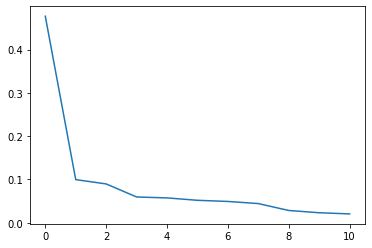

In [105]:
pca.fit(X[:,:20])
pyplot.plot(pca.explained_variance_ratio_)

In [79]:
X.shape

(3409, 11)

In [106]:
%load_ext autoreload
%autoreload 2
import numpy
from matplotlib import pyplot
import sys
sys.path.append('../../timeseries/')
sys.path.append('../../src/')
import factors
import observation_models
import state_models
from ssm_em import StateSpaceEM

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
Dz = 4
Dx = X.shape[1]
sm = state_models.LinearStateModel(Dz)
om = observation_models.LinearObservationModel(Dx, Dz)
om.pca_init(X[:2000,:])

In [109]:
ssm_em_lin = StateSpaceEM(X[:2000,:], observation_model=om, state_model=sm, conv_crit=1e-6)
ssm_em_lin.run()
pyplot.plot(ssm_em_lin.llk_list[1:])

Iteration 2 - llk=-25653.0
Iteration 4 - llk=-25652.7
Iteration 6 - llk=-25652.1
Iteration 8 - llk=-25651.6
Iteration 10 - llk=-25650.8
Iteration 12 - llk=-25649.3
Iteration 14 - llk=-25647.0
Iteration 16 - llk=-25645.1
Iteration 18 - llk=-25643.8


KeyboardInterrupt: 

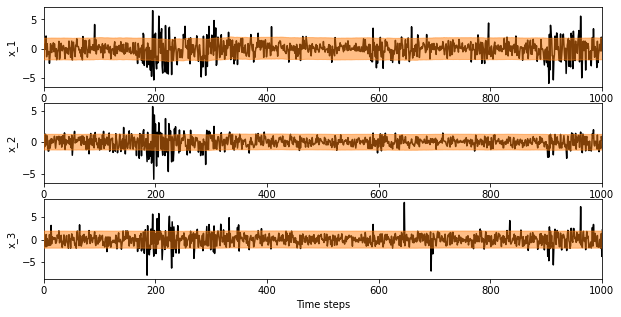

In [110]:
p_x = ssm_em_lin.compute_data_density()
pyplot.figure(figsize=(10,5))
for ix in range(3):
    pyplot.subplot(3,1,ix+1)
    ix += 0
    x_min = p_x.mu[:2000,ix] - 1.68 * numpy.sqrt(p_x.Sigma[:2000,ix,ix])
    x_max = p_x.mu[:2000,ix] + 1.68 * numpy.sqrt(p_x.Sigma[:2000,ix,ix])
    pyplot.plot(X[:2000,ix],'k')
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5, zorder=9)
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X[:1000].shape[0]])
pyplot.xlabel('Time steps')
pyplot.show()

In [113]:
Du = 4
Dz = 4
sm = state_models.LinearStateModel(Dz)
# Here we change the observation model.
om = observation_models.HCCovObservationModel(Dx, Dz, Du)
om.pca_init(X[:2000,:])

In [ ]:
ssm_em = StateSpaceEM(X[:2000,:], observation_model=om, state_model=sm, conv_crit=1e-4)
ssm_em.run()
pyplot.plot(ssm_em.llk_list[1:])
pyplot.xlabel('EM iterations')
pyplot.ylabel('Likelihood')
pyplot.show()

/opt/conda/lib/python3.8/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
../../timeseries/observation_models.py:792: RuntimeWarning: invalid value encountered in true_divide
  omega_star = numpy.sqrt(numpy.abs(quart_int / quad_int))
/opt/conda/lib/python3.8/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in cosh
  return f_raw(*args, **kwargs)
../../timeseries/observation_models.py:695: RuntimeWarning: overflow encountered in multiply
  return 2 * beta * numpy.cosh(h)
/opt/conda/lib/python3.8/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in sinh
  return f_raw(*args, **kwargs)
../../timeseries/observation_models.py:709: RuntimeWarning: overflow encountered in multiply
  return 2 * beta * numpy.sinh(h)
../../timeseries/observation_models.py:723: RuntimeWarning: invalid value encountered in true_divide
  return self.f_prime(omega, beta) / (self.sigma_x ** 2 + self.f(omeg

Iteration 2 - llk=-35947.1


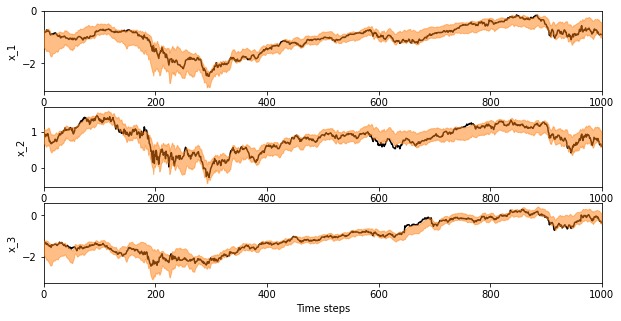

In [87]:
p_x = ssm_em.compute_data_density()
pyplot.figure(figsize=(10,5))
for ix in range(3):
    pyplot.subplot(3,1,ix+1)
    ix += 0
    x_min = p_x.mu[:1000,ix] - 1.68 * numpy.sqrt(p_x.Sigma[:1000,ix,ix])
    x_max = p_x.mu[:1000,ix] + 1.68 * numpy.sqrt(p_x.Sigma[:1000,ix,ix])
    pyplot.plot(X[:1000,ix],'k')
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5, zorder=9)
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X[:1000].shape[0]])
pyplot.xlabel('Time steps')
pyplot.show()

In [88]:
ssm_em.compute_predictive_log_likelihood(X[2000:])

-2505957.9363764795

In [89]:
ssm_em_lin.compute_predictive_log_likelihood(X[2000:])

-1684714.7456819282